In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##### ##### LOADING DATA
import numpy as np
import pandas as pd

BASE_FILE_PATH = "/content/drive/MyDrive/DataScience/Project/data"

##### LOADING JSON, CONVERTING TO CSV
TRAIN_DATA_PATH_JSON = BASE_FILE_PATH + "/train.json"
TEST_DATA_PATH_JSON = BASE_FILE_PATH + "/test.json"

train_data = pd.read_json(TRAIN_DATA_PATH_JSON, lines=True)
test_data = pd.read_json(TEST_DATA_PATH_JSON, lines=True)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

print("Train data head:\n", train_data.head())

Train data shape: (2400, 19)
Test data shape: (3634, 7)
Train data head:
    index  ...                                            deg_50C
0      0  ...  [0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...
1      1  ...  [7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...
2      2  ...  [0.9501000000000001, 1.7974999999999999, 1.499...
3      3  ...  [7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
4      4  ...  [0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,...

[5 rows x 19 columns]


In [ ]:
##### ##### PREPROCESSING DATA

import torch
from torch import nn

# Assigning each unique character its own integer identifier
# encoding_dict will be used in the models' embedding layers
def convert_to_encoding(data_frame, encoding_dict):
    cat_features = ["sequence", "structure", "predicted_loop_type"]
    for feature in cat_features:
        data_frame.loc[:, feature] = data_frame.loc[:, feature].apply(lambda row: [encoding_dict[x] for x in row])

    return np.array(data_frame[cat_features].values.tolist())

##### Splitting training data into training/validation sets
train_data = train_data.loc[train_data.SN_filter == 1]
train_data_shuffled = train_data.sample(frac=1)
EIGHTY_PERCENT = int(len(train_data_shuffled) * 0.8)
train_data = train_data_shuffled.iloc[:EIGHTY_PERCENT, :].reset_index(drop=True)
valid_data = train_data_shuffled.iloc[EIGHTY_PERCENT:, :].reset_index(drop=True)

##### Encoding each character of each string with convert_to_encoding()
encoding_dict = {}
data_chars = "ACGU().BEHIMSX"
for i in range(len(data_chars)):
    encoding_dict[data_chars[i]] = i

##### Encoding and reshaping training, validation, training data
output_cols = ["reactivity", "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"]

train_features = np.transpose(torch.Tensor(convert_to_encoding(train_data, encoding_dict)), (0, 2, 1))
train_labels = np.transpose(torch.Tensor(np.array(train_data[output_cols].values.tolist())), (0, 2, 1))

valid_features = np.transpose(torch.Tensor(convert_to_encoding(valid_data, encoding_dict)), (0, 2, 1))
valid_labels = np.transpose(torch.Tensor(np.array(valid_data[output_cols].values.tolist())), (0, 2, 1))

public_test_data = test_data.loc[test_data.seq_length == 107]
private_test_data = test_data.loc[test_data.seq_length == 130]
public_test_features = np.transpose(torch.Tensor(convert_to_encoding(public_test_data, encoding_dict)), (0, 2, 1))
private_test_features = np.transpose(torch.Tensor(convert_to_encoding(private_test_data, encoding_dict)), (0, 2, 1))

##### Sanity check
print("train_features shape:", train_features.shape)
print("train_labels shape:", train_labels.shape)
print()
print("valid_features shape:", valid_features.shape)
print("valid_labels shape:", valid_labels.shape)
print()
print("public_test_features shape:", public_test_features.shape)
print("private_test_features shape:", private_test_features.shape)

train_features shape: torch.Size([1271, 107, 3])
train_labels shape: torch.Size([1271, 68, 5])

valid_features shape: torch.Size([318, 107, 3])
valid_labels shape: torch.Size([318, 68, 5])

public_test_features shape: torch.Size([629, 107, 3])
private_test_features shape: torch.Size([3005, 130, 3])


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
##### ##### MODELS

##### Simple LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.embedding = nn.Embedding(len(encoding_dict), 150)
        self.lstm = nn.LSTM(input_size=450, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True, dropout=0.5)
        self.linear = nn.Linear(512, 5)
    
    def forward(self, xb, num_scored):
        # Passing input through embedding layer.
        # Embedding layer adds new dimension, so we need to reshape
        xb = self.embedding(xb)
        xb = torch.reshape(xb, (-1, xb.shape[1], xb.shape[2] * xb.shape[3]))

        xb, _ = self.lstm(xb)
        xb = xb[:, :num_scored, :]
        xb = self.linear(xb)

        return xb

##### LSTM + Convolutional model
class LSTM_Alt(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.embedding = nn.Embedding(len(encoding_dict), 150)
        self.lstm = nn.LSTM(input_size=450, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True, dropout=0.5)
        self.conv = nn.Conv1d(107, 107, 1)
        self.linear = nn.Linear(512, 128)
        self.linear2 = nn.Linear(128, 5)
        # self.linear3 = nn.Linear(32, 5)
    
    def forward(self, xb, num_scored):
        # Passing input through embedding layer.
        # Embedding layer adds new dimension, so we need to reshape
        xb = self.embedding(xb)
        xb = torch.reshape(xb, (-1, xb.shape[1], xb.shape[2] * xb.shape[3]))

        xb, _ = self.lstm(xb)
        xb = self.conv(xb)
        xb = xb[:, :num_scored, :]
        xb = self.linear(xb)
        xb = self.linear2(xb)

        return xb

##### Linear model (baseline)
class Linear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 5)
    
    def forward(self, xb, num_scored):
        xb = xb[:, :num_scored, :]
        xb = self.linear(xb)
        return xb

In [ ]:
##### ##### LOSS FUNCTION

class MCRMSE_Loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, yhat, y):
        mse = torch.mean(torch.square(yhat - y))
        return torch.mean(torch.sqrt(mse))

In [ ]:
##### ##### TRAINING AND VALIDATION

from torch.utils.data import Dataset, DataLoader, TensorDataset

##### HYPER PARAMETERS
num_epochs = 45 
batch_size = 32
learning_rate = 0.001


device = 'cuda'
criterion = MCRMSE_Loss()
models = [LSTM(3).to(device), LSTM_Alt(3).to(device), Linear(3).to(device)]

# From when I was doing one model at a time
# model = LSTM(3).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

train_dataset = TensorDataset(train_features, train_labels)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(valid_features, valid_labels)
valid_iter = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

public_test_dataset = TensorDataset(public_test_features)
private_test_dataset = TensorDataset(private_test_features)
public_test_iter = DataLoader(public_test_dataset, shuffle=False)
private_test_iter = DataLoader(private_test_dataset, shuffle=False)

all_train_losses = []
all_valid_losses = []

for i in range(len(models)):
    train_losses = []
    valid_losses = []

    model = models[i]
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_loss_batch = []

        for X, y in train_iter:
            if i == 2:
                X, y = X.cuda(), y.cuda()
            else:
                X, y = X.to(torch.long).cuda(), y.cuda()

            y_hat = model(X, 68)
            loss = criterion(y_hat, y)
            train_loss_batch.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss = sum(train_loss_batch) / len(train_loss_batch)
        train_losses.append(train_loss)

        valid_loss = 0.0
        valid_loss_batch = []
        model.eval()
        with torch.no_grad():
            for X, y in valid_iter:
                if i == 2:
                    X, y = X.cuda(), y.cuda()
                else:
                    X, y = X.to(torch.long).cuda(), y.cuda()

                y_hat = model(X, 68)
                loss = criterion(y_hat, y)
                valid_loss_batch.append(loss)
        
        valid_loss = sum(valid_loss_batch) / len(valid_loss_batch)
        valid_losses.append(valid_loss)

        print("Epoch " + str(epoch) + ", train loss: " + str(train_loss.item()))
        print("Valid loss:", str(valid_loss.item()))

        # lr_scheduler.step()   # Did not end up using LR scheduler
    
    all_train_losses.append(train_losses)
    all_valid_losses.append(valid_losses)
    

Epoch 0, train loss: 0.39667317271232605
Valid loss: 0.33820122480392456
Epoch 1, train loss: 0.32157668471336365
Valid loss: 0.3118857443332672
Epoch 2, train loss: 0.3044237196445465
Valid loss: 0.2989290952682495
Epoch 3, train loss: 0.29154106974601746
Valid loss: 0.29065462946891785
Epoch 4, train loss: 0.2823096215724945
Valid loss: 0.28817030787467957
Epoch 5, train loss: 0.272491455078125
Valid loss: 0.27341270446777344
Epoch 6, train loss: 0.26335713267326355
Valid loss: 0.2676181495189667
Epoch 7, train loss: 0.2576717138290405
Valid loss: 0.2634415328502655
Epoch 8, train loss: 0.25328925251960754
Valid loss: 0.25916197896003723
Epoch 9, train loss: 0.24735939502716064
Valid loss: 0.2580049932003021
Epoch 10, train loss: 0.2404182255268097
Valid loss: 0.251766175031662
Epoch 11, train loss: 0.2369290441274643
Valid loss: 0.2511102855205536
Epoch 12, train loss: 0.23179025948047638
Valid loss: 0.24692487716674805
Epoch 13, train loss: 0.2285417765378952
Valid loss: 0.24770891

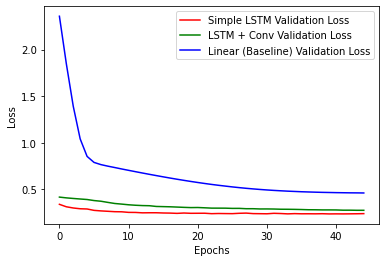

In [ ]:
##### ##### VISUALIZING LOSS OVER TIME
import matplotlib.pyplot as plt
%matplotlib inline

epochs_list = range(num_epochs)
# plt.plot(epochs_list, train_losses, 'bo-', label='Training Loss')     # Not showing training loss
plt.plot(epochs_list, all_valid_losses[0], 'r', label='Simple LSTM Validation Loss')
plt.plot(epochs_list, all_valid_losses[1], 'g', label='LSTM + Conv Validation Loss')
plt.plot(epochs_list, all_valid_losses[2], 'b', label='Linear (Baseline) Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
##### ##### TESTING
public_preds = []
private_preds = []
model = models[0]

public_preds = np.zeros((0, 107, 5))
private_preds = np.zeros((0, 130, 5))
model.eval()
with torch.no_grad():
    for X in public_test_iter:
        X = X[0].to(torch.int64).cuda()
        pred = model(X, 107)

        public_preds = np.concatenate([public_preds, pred.cpu()], axis=0)
    
    for X in private_test_iter:
        X = X[0].to(torch.int64).cuda()
        pred = model(X, 130)

        private_preds = np.concatenate([private_preds, pred.cpu()], axis=0)

print("public_preds shape:", public_preds.shape)
print("private_preds shape:", private_preds.shape)

public_preds shape: (629, 107, 5)
private_preds shape: (3005, 130, 5)


In [ ]:
##### ##### COMBINING OUTPUT PREDICTIONS 
i = 0
public_submission = np.zeros((0, 6))
public_submission = pd.DataFrame(public_submission, columns=["id_seqpos", "reactivity", "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"])

for id in public_test_data["id"]:
    submission_batch = pd.DataFrame(public_preds[i], columns=output_cols)
    id_list = []

    for j in range(public_preds[i].shape[0]):
        id_list.append(str(id) + "_" + str(j) )
    submission_batch["id_seqpos"] = id_list

    public_submission = pd.concat([public_submission, submission_batch])

    i += 1

private_submission = np.zeros((0, 6))
private_submission = pd.DataFrame(private_submission, columns=["id_seqpos", "reactivity", "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"])

i = 0
for id in private_test_data["id"]:
    submission_batch = pd.DataFrame(private_preds[i], columns=output_cols)
    id_list = []

    for j in range(private_preds[i].shape[0]):
        id_list.append(str(id) + "_" + str(j) )
    submission_batch["id_seqpos"] = id_list

    private_submission = pd.concat([private_submission, submission_batch])

    i += 1

print("public_submission shape:", public_submission.shape)
print("private_submission shape:", private_submission.shape)

submission = pd.concat([public_submission, private_submission])
submission = submission.reset_index(drop=True)

print()
print("submission shape:", submission.shape)
print("submission head:", submission.head())
     

public_submission shape: (67303, 6)
private_submission shape: (390650, 6)

submission shape: (457953, 6)
submission head:         id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
0  id_00073f8be_0    1.009932     0.748724  1.922320    0.691993  0.815671
1  id_00073f8be_1    3.061346     3.559828  4.553716    3.647369  3.038272
2  id_00073f8be_2    1.798041     0.647612  0.746818    0.707006  0.791971
3  id_00073f8be_3    1.630163     1.461275  1.439296    1.985584  1.908636
4  id_00073f8be_4    1.065874     0.735369  0.809032    1.082201  1.070072


In [ ]:
##### ##### SAVING TO .CSV
submission.to_csv("/content/drive/MyDrive/DataScience/Project/submission.csv", index=False)
